<a href="https://colab.research.google.com/github/Prajay404/QCNNFORQSO/blob/main/SMBH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [10/80], Loss: 2.1726, Accuracy: 0.0370, F1 Score: 0.0000
Epoch [20/80], Loss: 1.3358, Accuracy: 0.2963, F1 Score: 0.4242
Epoch [30/80], Loss: 0.8480, Accuracy: 0.4074, F1 Score: 0.5556
Epoch [40/80], Loss: 0.5867, Accuracy: 0.5556, F1 Score: 0.7143
Epoch [50/80], Loss: 0.4447, Accuracy: 0.6296, F1 Score: 0.7727
Epoch [60/80], Loss: 0.3579, Accuracy: 0.7037, F1 Score: 0.8261
Epoch [70/80], Loss: 0.2978, Accuracy: 0.8889, F1 Score: 0.9412
Epoch [80/80], Loss: 0.2537, Accuracy: 0.9259, F1 Score: 0.9615
Mean Squared Error: 0.1587
Accuracy: 0.9259
F1 Score: 0.9615
Confusion Matrix:
[[ 0  1]
 [ 1 25]]


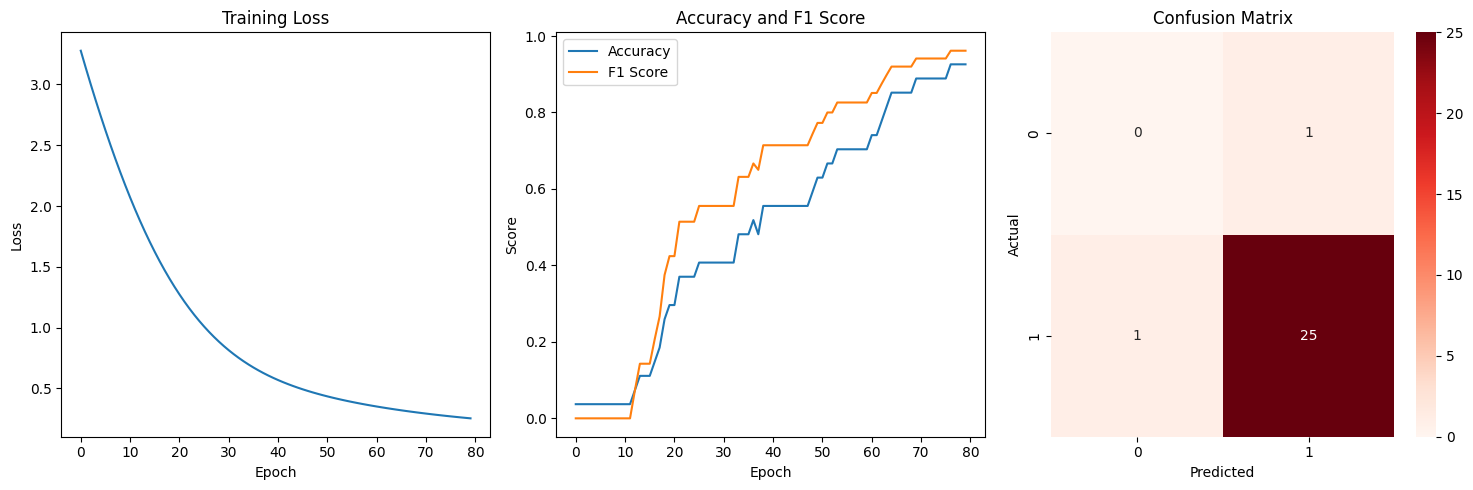

In [7]:
!pip install pennylane matplotlib seaborn

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import pennylane as qml
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('/content/galaxy_data.csv')

# Use all columns except 'black_hole_mass' as features
features = [col for col in df.columns if col != 'black_hole_mass']
X = df[features]
y = df['black_hole_mass']

# Preprocess the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Define the quantum device
n_qubits = len(features)  # One qubit for each feature
dev = qml.device("default.qubit", wires=n_qubits)

# Define the quantum circuit
@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define the QCNN model
class QCNN(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super().__init__()
        self.n_qubits = n_qubits
        self.q_layers = nn.Parameter(torch.randn(n_layers, n_qubits, 3))
        self.fc = nn.Linear(n_qubits, 1)

    def forward(self, x):
        x = torch.tensor([quantum_circuit(x_i, self.q_layers) for x_i in x], dtype=torch.float32)
        return self.fc(x)

# Initialize the model
model = QCNN(n_qubits=n_qubits, n_layers=2)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Initialize lists to store metrics
losses = []
accuracies = []
f1_scores = []

# Training loop
n_epochs = 80
batch_size = 32
threshold = 0.90

for epoch in range(n_epochs):
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Calculate metrics
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        y_pred_binary = (y_pred > threshold).float()
        y_test_binary = (y_test > threshold).float()
        accuracy = accuracy_score(y_test_binary, y_pred_binary)
        f1 = f1_score(y_test_binary, y_pred_binary)

    losses.append(epoch_loss / (len(X_train) // batch_size))
    accuracies.append(accuracy)
    f1_scores.append(f1)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss/(len(X_train)//batch_size):.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')

# Final evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    mse = criterion(y_pred, y_test)
    print(f'Mean Squared Error: {mse.item():.4f}')

y_pred_binary = (y_pred > threshold).float()
y_test_binary = (y_test > threshold).float()
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f'Accuracy: {accuracy:.4f}')

f1 = f1_score(y_test_binary, y_pred_binary)
print(f'F1 Score: {f1:.4f}')

cm = confusion_matrix(y_test_binary, y_pred_binary)
print('Confusion Matrix:')
print(cm)

# Visualizations
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(131)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Accuracy and F1 Score plot
plt.subplot(132)
plt.plot(accuracies, label='Accuracy')
plt.plot(f1_scores, label='F1 Score')
plt.title('Accuracy and F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

# Confusion Matrix
plt.subplot(133)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()